In [1]:
import sys
import os

src_path = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "src"))
sys.path.append(src_path)
print("Updated sys.path:", sys.path)

from utility import plot_settings  # Custom styling module
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

Updated sys.path: ['c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env\\python311.zip', 'c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env\\DLLs', 'c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env\\Lib', 'c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env', '', 'C:\\Users\\sebas\\AppData\\Roaming\\Python\\Python311\\site-packages', 'c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env\\Lib\\site-packages', 'c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env\\Lib\\site-packages\\win32', 'c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\sebas\\Anaconda3\\envs\\time_series_env\\Lib\\site-packages\\Pythonwin', 'c:\\Users\\sebas\\Documents\\Data_Science\\14-Dave_Ebbelaar\\Predicting_with_sktime\\src']


In [2]:
df_ts = pd.read_csv("../../data/interim/sales_ts.csv")

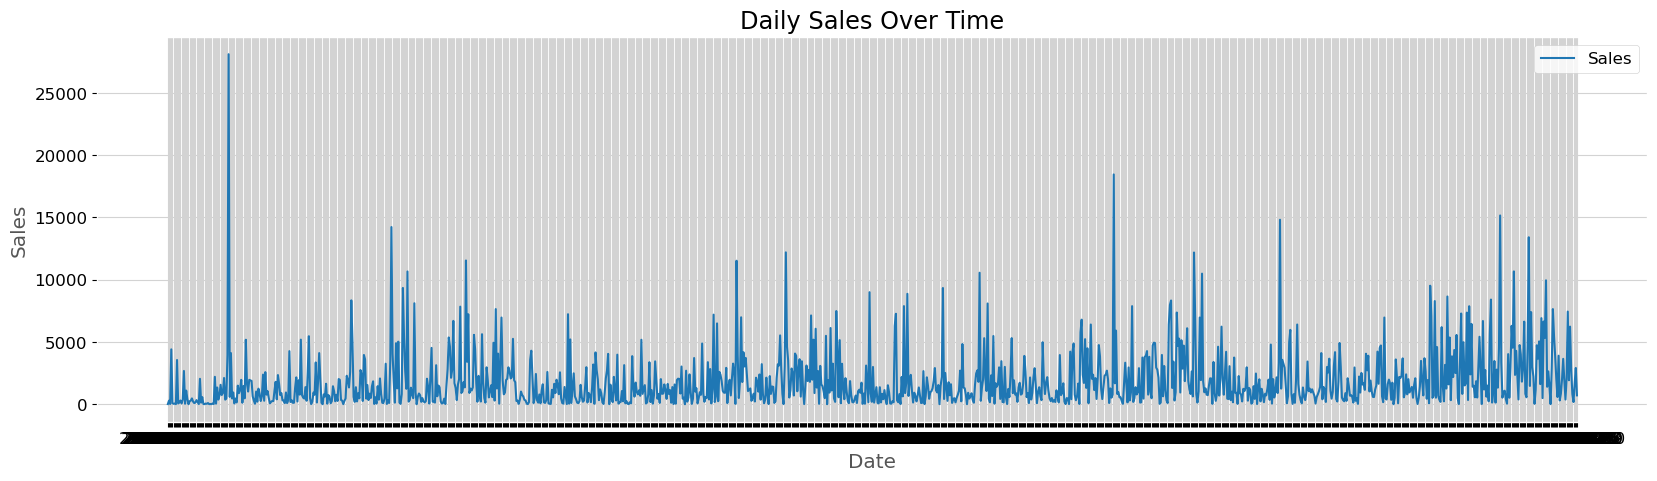

In [9]:
# Plot sales over time with custom style
plt.plot(df_ts["order_date"], df_ts["sales"], label="Sales")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Daily Sales Over Time")
plt.legend()
plt.show()

**Overall Trend**
- **Upward Movement**: The decomposition’s trend component steadily rises from around 2015 to late 2018. This suggests an **overall increase in sales** over the four-year period.
- **Magnitude of Increase**: The trend line moves from roughly 1,000–1,500 in daily sales to around 2,000–2,500, indicating a noticeable growth trajectory.

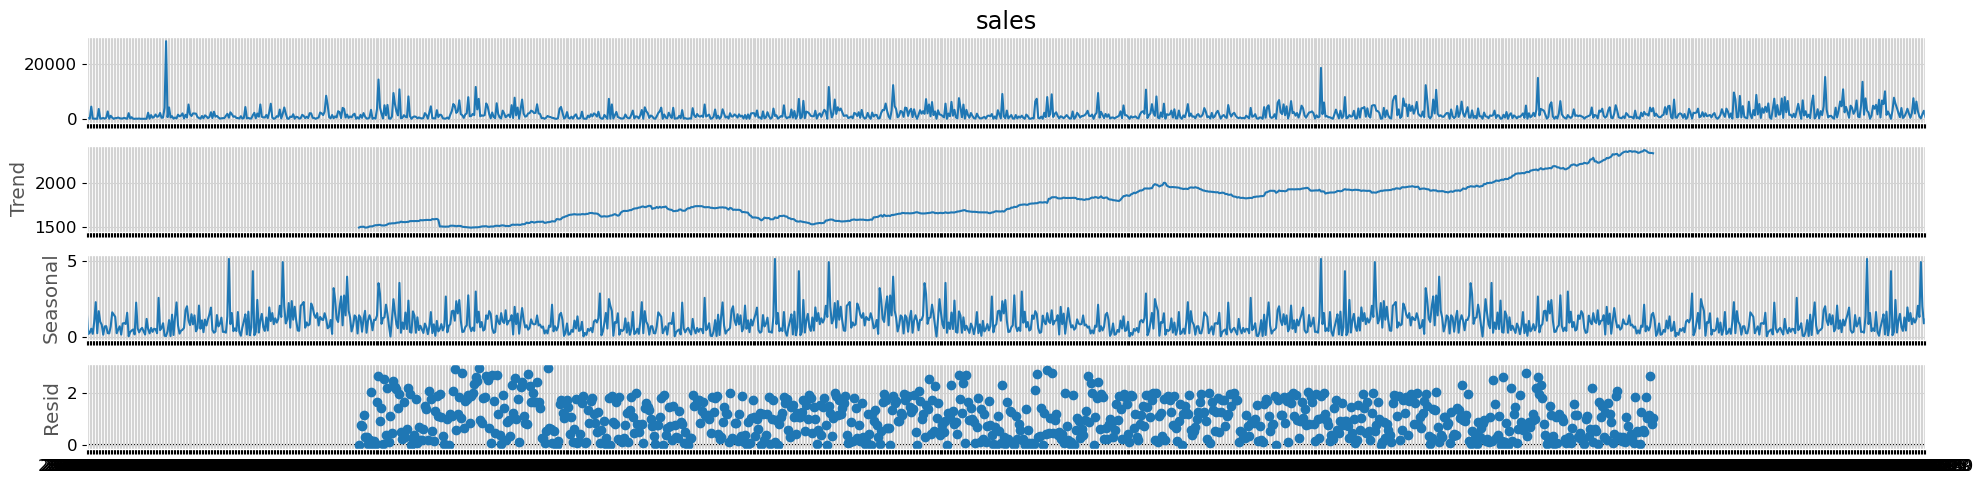

In [10]:
# Decompose Time Series (Trend, Seasonality, Residuals)
decomposition = seasonal_decompose(
    df_ts.set_index("order_date")["sales"], model="multiplicative", period=365
)

decomposition.plot()
plt.show()

**Seasonality**
- **Annual Pattern (period=365)**: The seasonal component in the decomposition chart shows a **repeating pattern** across the years, but it’s relatively **moderate** in amplitude. 
- **Possible Monthly or Quarterly Cycles**: Although the decomposition was set to an annual frequency (period=365), the visible undulations may align with **monthly or quarterly** sales cycles—common in retail due to holidays or end-of-quarter purchasing. 
- **Further Investigation**: If you suspect weekly or monthly patterns, consider adjusting the period parameter or using other methods (e.g., Fourier terms in Prophet) to detect **shorter-term** seasonality.

---

**Spikes and Potential Outliers**
- **High Peaks**: The daily sales time series shows several **large spikes** exceeding 10,000–20,000. These could be:
  - **Promotional Events**: Discounts, Black Friday, Cyber Monday, or other sales campaigns.
  - **Bulk/Corporate Orders**: Single large orders can cause sharp daily increases.
- **Impact on Model**: Spikes can heavily influence model training, so it’s worth examining these days more closely to see if they correspond to known **events** or if they’re genuine outliers (data errors).

---

**Residuals (Decomposition)**
- **Random Distribution**: The residuals appear **scattered** without a clear pattern, indicating that most systematic information (trend + seasonality) has been captured by the decomposition.
- **Potential Heteroskedasticity**: Some residual points are quite large, suggesting that variance might differ over time. Check if certain periods are more volatile than others.

In [ ]:
# Check for stationarity (ADF Test)
result = adfuller(df_ts["sales"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] <= 0.05:
    print("✅ The time series is stationary.")
else:
    print("❌ The time series is NOT stationary. Differencing may be needed.")

ADF Statistic: -5.761112092918489
p-value: 5.669526815779762e-07
✅ The time series is stationary.


**Stationarity**
- **ADF Test**: The ADF statistic is **-5.76** with a **p-value ≈ 5.67e-07**, strongly suggesting the series is **stationary** in its current form.
- **Implication for ARIMA**: A stationary time series is suitable for **ARIMA-based** modeling without additional differencing. However, the upward trend in the decomposition might typically conflict with strict stationarity. It’s possible that the strong short-term fluctuations overshadow the longer-term trend in the ADF test, but practically, you may still want to **check differenced data** or rely on Prophet (which can handle non-stationary trends).

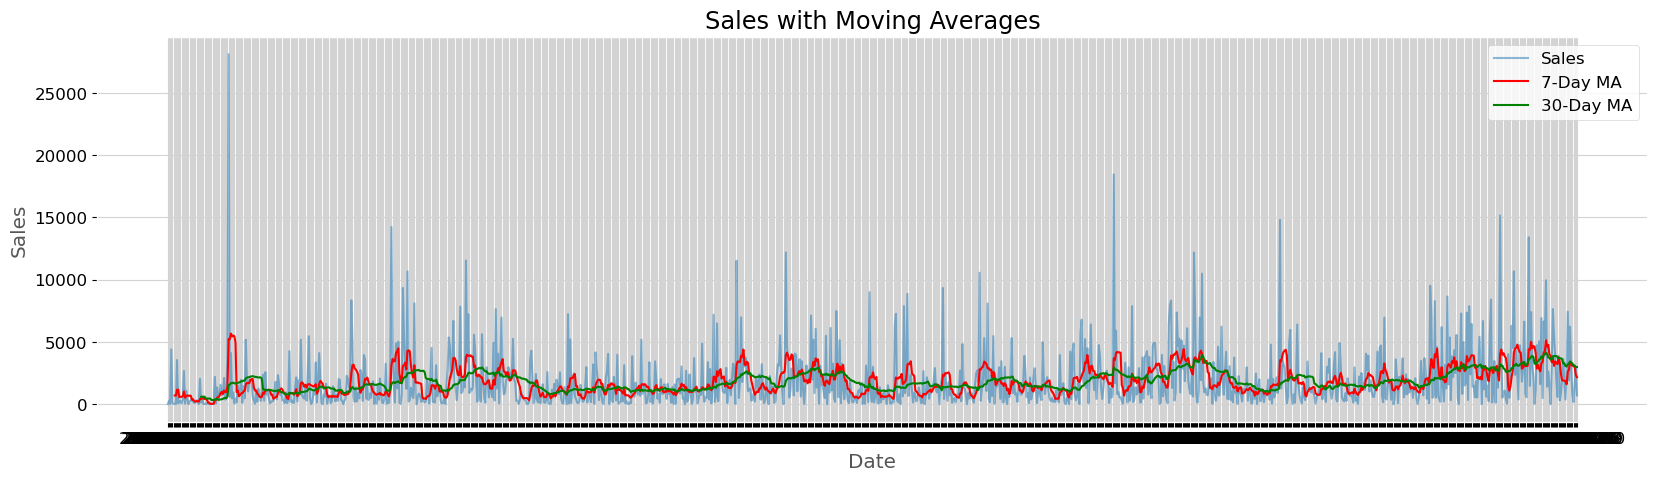

In [12]:
# Compute moving averages
df_ts["7-day MA"] = (
    df_ts["sales"].rolling(window=7).mean()
)  # The 7-day MA smooths out weekly fluctuations
df_ts["30-day MA"] = (
    df_ts["sales"].rolling(window=30).mean()
)  # The 30-day MA shows longer-term trends

# Plot moving averages
plt.plot(df_ts["order_date"], df_ts["sales"], label="Sales", alpha=0.5)
plt.plot(df_ts["order_date"], df_ts["7-day MA"], label="7-Day MA", color="red")
plt.plot(df_ts["order_date"], df_ts["30-day MA"], label="30-Day MA", color="green")

plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Sales with Moving Averages")
plt.legend()
plt.show()

**key takeaways:**

1. **Smoothing of Daily Volatility**  
   - The raw sales data (blue line) exhibits **large, frequent spikes**, which can make it difficult to discern underlying patterns.  
   - The **7-Day MA (red line)** smooths out some of this day-to-day noise, while still responding relatively quickly to changes in sales levels (e.g., promotions or seasonal peaks).  
   - The **30-Day MA (green line)** provides an even smoother trend line, reducing short-term fluctuations to highlight longer-term trends.

2. **Short-Term vs. Long-Term Trends**  
   - **7-Day MA:** Offers a weekly perspective. If you see a sudden rise or dip here, it may reflect short-term events (promotional campaigns, holidays, or one-off bulk orders).  
   - **30-Day MA:** Shows a monthly perspective, capturing broader shifts in sales levels. A noticeable climb or decline here often points to more sustained trends (e.g., a new product launch’s lasting impact or a gradual season change in demand).

3. **Identifying Spikes and Seasonal Patterns**  
   - When the daily sales (blue) diverge significantly from both moving averages, it signals **anomalies** (outliers) or **major sales spikes**.  
   - If the 7-day average consistently exceeds the 30-day average for a period, it suggests a **short-term upswing** in sales; the opposite may indicate a recent drop.

4. **Business Insights**  
   - **Promotional Effectiveness:** A sudden lift in both MAs might confirm the sustained impact of a marketing campaign.  
   - **Inventory and Supply Chain Planning:** Seeing how quickly the 7-day average rebounds after spikes can guide how to manage stock for short-lived surges in demand.  
   - **Long-Term Growth or Decline:** The 30-day MA is useful for evaluating whether the business is on an upward or downward trajectory over a month or longer.

Overall, these moving averages help you look beyond day-to-day noise to detect **meaningful trends** and **seasonal cycles** in the sales data, informing better forecasting and strategic decision-making.

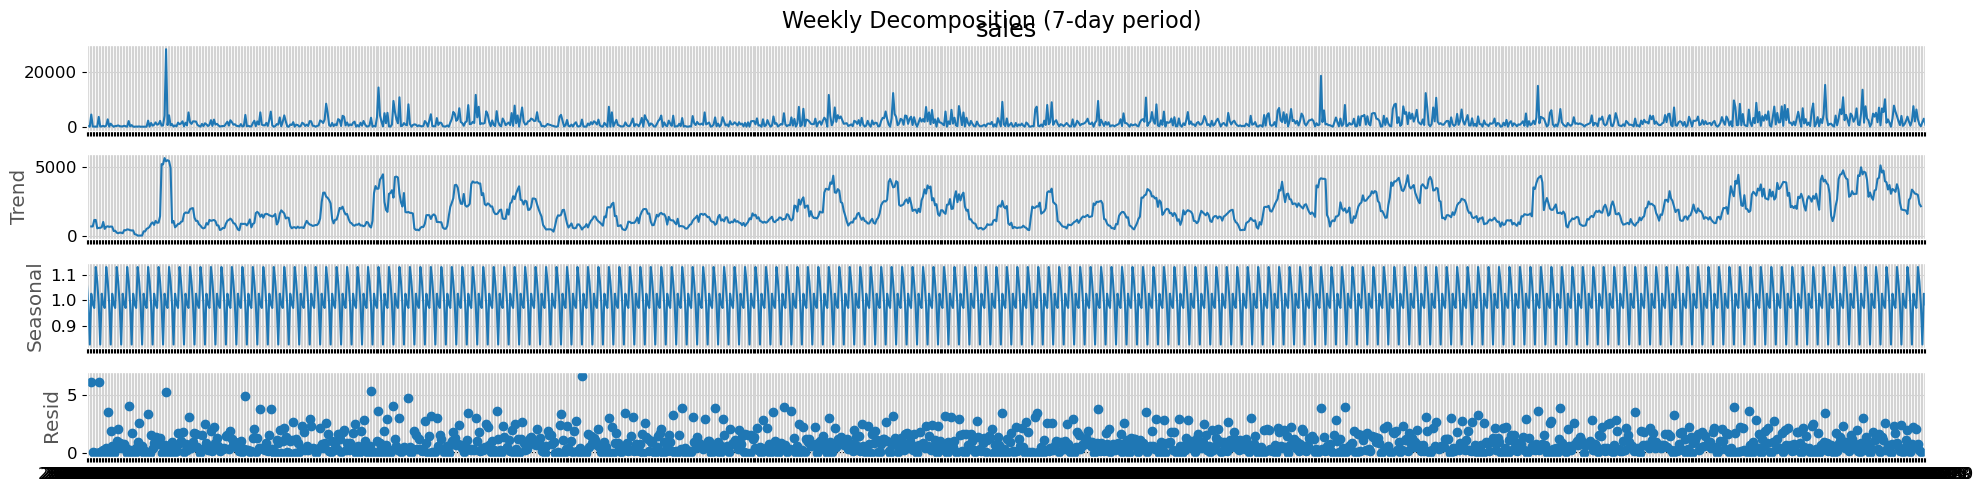

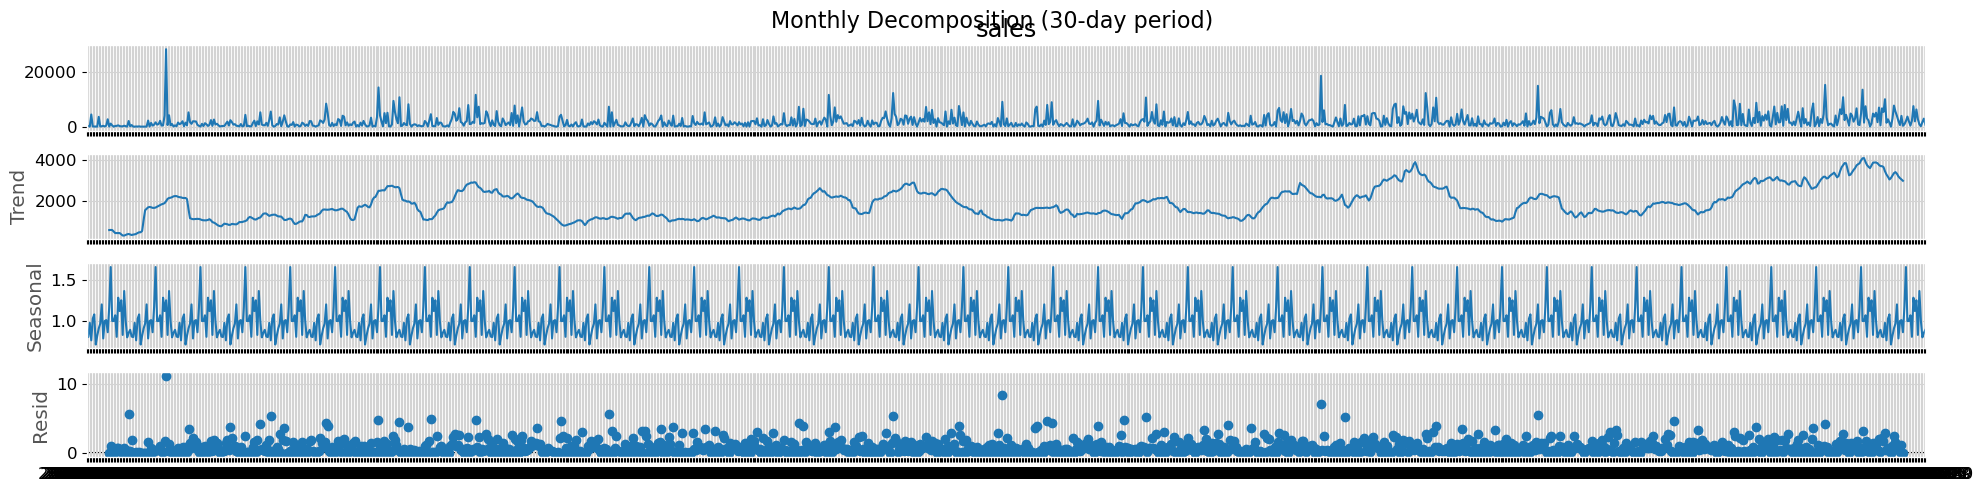

In [13]:
# Weekly Seasonality (period = 7)
decomp_weekly = seasonal_decompose(
    df_ts.set_index("order_date")["sales"], model="multiplicative", period=7
)
decomp_weekly.plot()
plt.suptitle("Weekly Decomposition (7-day period)", fontsize=16)
plt.show()

# Monthly Seasonality (approx. 30 days)
decomp_monthly = seasonal_decompose(
    df_ts.set_index("order_date")["sales"], model="multiplicative", period=30
)
decomp_monthly.plot()
plt.suptitle("Monthly Decomposition (30-day period)", fontsize=16)
plt.show()

Below are the main insights you can draw from the **weekly** (`period=7`) and **monthly** (`period=30`) seasonal decompositions shown in the plots. 

---

**1. Weekly Decomposition (7-day Period)**

1. **Observed Series**  
   - Shows frequent spikes, indicating substantial day-to-day volatility in sales.  
   - We can notice peaks and troughs at roughly weekly intervals.

2. **Trend**  
   - Overall, the trend may still show a gradual increase over the multi-year span (2015–2018).  
   - However, the weekly decomposition’s trend line can be somewhat smoother because shorter-term fluctuations (weekly seasonality) are stripped out.

3. **Seasonal Component**  
   - With `period=7`, we’re capturing **day-of-week patterns**. For instance, some businesses see higher sales on Mondays and Fridays, with dips mid-week or on weekends.  
   - If the seasonal line repeats a distinct shape every 7 data points, it confirms that certain days consistently have higher or lower sales.

4. **Residual**  
   - Whatever is left after removing the trend and the 7-day cycle. If the residual variance is still high, it indicates there are additional factors (promotions, holidays, random fluctuations) not captured by this weekly pattern alone.

**Key Weekly Insight**  
A strong weekly pattern means day-of-week effects matter. If we see consistent spikes or dips on specific days, we might want to incorporate that into our forecasting approach (e.g., Prophet’s built-in weekly seasonality or an ARIMA model with external regressors indicating the day of the week).

---

**2. Monthly Decomposition (30-day Period)**

1. **Observed Series**  
   - Again, high variability day-to-day, but now we look for **monthly** repeating cycles.

2. **Trend**  
   - The monthly trend line should look similar to the weekly one in its broad shape, still showing that longer-term increase or plateau.  
   - Because `period=30` is coarser than 7, we might see a slightly smoother trend line, as monthly seasonality is factored out.

3. **Seasonal Component**  
   - Shows a repeating pattern every 30 days (roughly monthly).  
   - In retail, we may see end-of-month spikes (e.g., paydays), or other periodic events.  
   - The amplitude (height of peaks and depth of troughs) in this monthly pattern may be less pronounced than the weekly pattern if most of our seasonality is actually day-of-week driven.

4. **Residual**  
   - Any short-term, random, or event-driven variations not explained by a 30-day cycle or the overall trend.  
   - If residuals remain large, it suggests daily-level volatility, promotions, or holidays that a simple 30-day seasonality doesn’t capture.

**Key Monthly Insight**  
Some businesses experience stronger monthly cycles (e.g., large orders at the start/end of each month). If that’s relevant for our domain, we’ll see a clearer repetitive pattern. If the seasonal amplitude is small, monthly effects may not be as critical as weekly ones.

---

**3. Overall Observations & Next Steps**

1. **Which Seasonality is Stronger?**  
   - If the 7-day seasonal plot shows a pronounced, consistent wave, we have stronger **weekly seasonality**.  
   - If the 30-day seasonal pattern is noticeable, we might also have **monthly cycles**—though in many retail contexts, day-of-week effects can overshadow monthly patterns.

2. **Residual Fluctuations**  
   - Large residuals mean there are still important factors not captured by these decompositions (e.g., holidays, one-off promotions, external market factors).  
   - Consider adding external regressors or using a more flexible model (e.g., Prophet with holiday/event inputs).

3. **Incorporating Multiple Seasonalities**  
   - **Prophet** naturally handles **daily**, **weekly**, and **yearly** seasonality. We can also add custom seasonalities (e.g., monthly).  
   - For ARIMA-based approaches, consider **SARIMA** or **AutoARIMA** with seasonal terms that match your identified patterns.

4. **Practical Modeling Approach**  
   - If weekly seasonality is dominant, ensure your model captures day-of-week effects.  
   - If monthly patterns matter, you may want a 30-day seasonal component or at least account for end-of-month cycles.  
   - Use **MLflow** (or similar) to track model versions, hyperparameters, and performance across different seasonal assumptions.

---

**Conclusion**  
- **Weekly Decomposition**: Likely reveals consistent day-of-week patterns.  
- **Monthly Decomposition**: Highlights broader, monthly cycles if they exist.  
- **Residual**: Suggests potential additional factors not explained by these frequencies alone.  

The final modeling strategy should reflect whichever seasonal components are most prominent and relevant to your business context, ensuring the model captures both the strong weekly patterns and any significant monthly cycles.

In [3]:
# Read CSV while parsing dates
total_sales_df = pd.read_csv(
    "../../data/interim/total_sales.csv", index_col=0, parse_dates=True
    )

In [4]:
total_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1230 entries, 2015-01-03 to 2018-12-30
Data columns (total 17 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Accessories  505 non-null    float64
 1   Appliances   363 non-null    float64
 2   Art          522 non-null    float64
 3   Binders      772 non-null    float64
 4   Bookcases    199 non-null    float64
 5   Chairs       411 non-null    float64
 6   Copiers      65 non-null     float64
 7   Envelopes    214 non-null    float64
 8   Fasteners    193 non-null    float64
 9   Furnishings  588 non-null    float64
 10  Labels       286 non-null    float64
 11  Machines     104 non-null    float64
 12  Paper        721 non-null    float64
 13  Phones       566 non-null    float64
 14  Storage      552 non-null    float64
 15  Supplies     166 non-null    float64
 16  Tables       253 non-null    float64
dtypes: float64(17)
memory usage: 173.0 KB


In [27]:
# Lets break the dataset by thirds for low, mid, high
avg_daily_sales = total_sales_df.apply(np.mean, axis=0).sort_values()
low, mid = np.percentile(total_sales_df.apply(np.mean, axis=0).sort_values(), [33, 66])

low_vol_columns = list(avg_daily_sales[avg_daily_sales <= low].index)
mid_vol_columns = avg_daily_sales[
    (avg_daily_sales > low) & (avg_daily_sales < mid)
].index
high_vol_columns = avg_daily_sales[avg_daily_sales >= mid].index

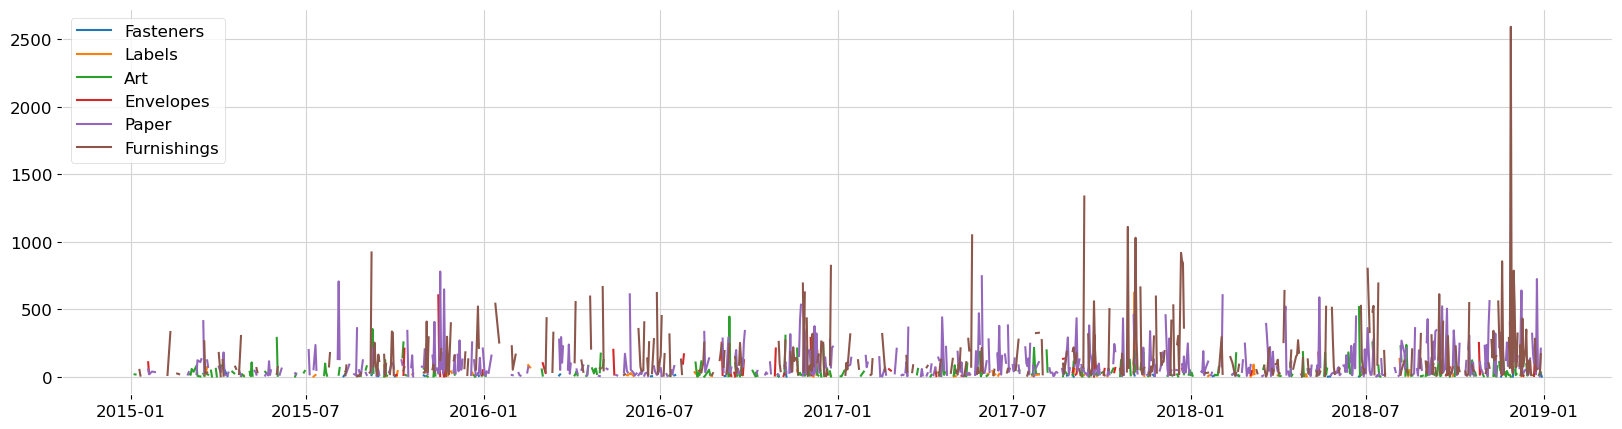

In [28]:
# PLot low volume
plt.plot(total_sales_df[low_vol_columns])
plt.legend(low_vol_columns, loc="best")  # , bbox_to_anchor=(1.1, 1.1))
plt.show()

**Low-Volume Subcategories**

**Observations**
- **Sparse & Sporadic Sales:**  
  The lines for low-volume categories often hover near zero, with occasional spikes. This suggests intermittent demand, which is typical for subcategories purchased infrequently or in small quantities.
- **Volatility:**  
  Even a modest jump in sales (e.g., from near-zero to 100) can appear as a large spike proportionally, potentially skewing forecasts.

**Recommendations**
1. **Consider Aggregation or Specialized Models:**  
   - **Aggregation:** If multiple low-volume subcategories share similar characteristics (e.g., same product family, similar customers), you can combine them into a single aggregated time series for more stable demand signals.  
2. **Business Value Assessment:**  
   - Evaluate whether forecasting these low-volume subcategories **individually** justifies the complexity. If their contribution to overall revenue is minimal, consider a simpler approach (e.g., rolling average, or a group-level forecast).

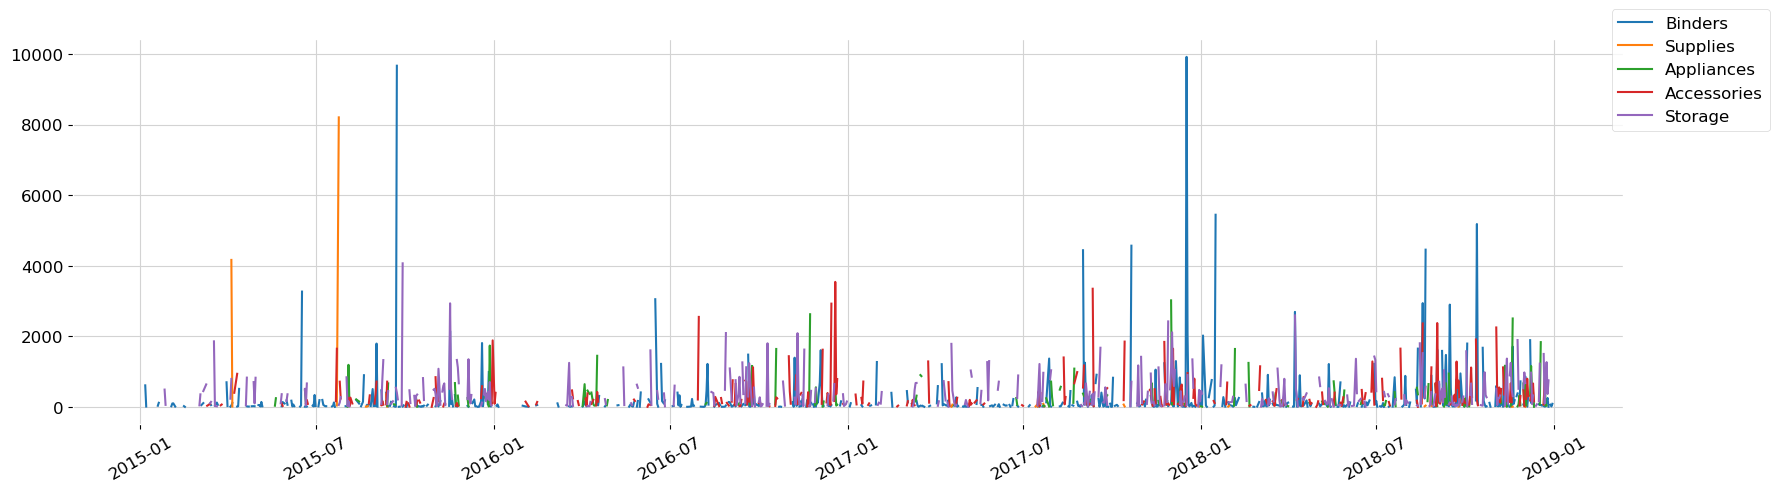

In [29]:
# Plot mid volume
plt.plot(total_sales_df[mid_vol_columns])
plt.legend(mid_vol_columns, loc="best", bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

**Mid-Volume Subcategories**

**Observations**
- **Moderate Demand Patterns:**  
  These show more frequent sales than low-volume categories but still display noticeable spikes.
- **Potential Seasonality or Trends:**  
  You might observe subtle recurring patterns or a mild upward/downward trend, though not as pronounced as in high-volume groups.

**Recommendations**
1. **Closer Look at Spikes:**  
   - Identify if spikes align with known promotions, new product launches, or random outliers.  
   - If they’re valid promotional events, keep them and possibly engineer “promotion” or “event” features for better forecasting accuracy.
2. **Seasonality Check:**  
   - Consider a weekly or monthly decomposition to see if these mid-volume categories exhibit a consistent pattern (e.g., end-of-month spikes).
3. **Modeling Approach:**  
   - **AutoARIMA or Prophet** can handle moderate data well, but we should confirm if the data is sufficiently dense (i.e., not too many zeros) for ARIMA-based methods.

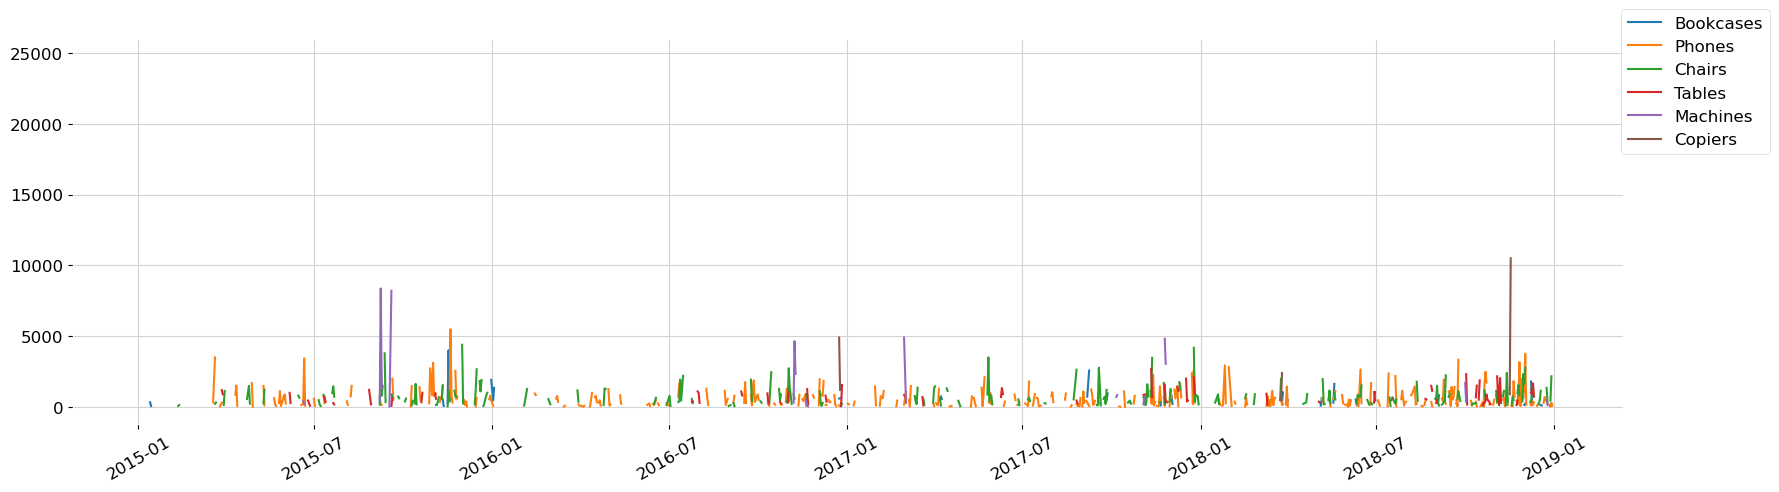

In [30]:
# pLot high volume
plt.plot(total_sales_df[high_vol_columns])
plt.legend(high_vol_columns, loc="best", bbox_to_anchor=(1.1, 1.1))
plt.xticks(rotation=30)
plt.show()

**High-Volume Subcategories**

**Observations**
- **Frequent Sales with Pronounced Spikes:**  
  Large swings may indicate bulk orders or heavy promotional periods. The spikes are more substantial but also reflect higher baseline sales.
- **Likely Stronger Trend & Seasonality:**  
  High-volume categories often show clearer trends or seasonal cycles (e.g., holiday peaks) because there’s more consistent demand.

**Recommendations**
1. **Investigate Large Peaks:**  
   - Validate whether they correspond to known events (Black Friday, holiday sales, corporate orders).  
   - If they are outliers with no business explanation, decide whether to cap or remove them, or incorporate them as “special events” in your forecast model.
2. **Advanced Forecasting Techniques:**  
   - **Prophet** handles multiple seasonalities (yearly, weekly) well and can incorporate holiday/event regressors.  
   - **AutoARIMA** is also suitable, especially if the data is stationary or can be made stationary through differencing.
3. **Potential for More Granular Analysis:**  
   - Because these categories contribute the most to revenue, we might invest in deeper feature engineering (e.g., marketing spend, competitor pricing, etc.) if data is available.

---

**In summary**, breaking the dataset into low-, mid-, and high-volume subcategories provides valuable insight into how different segments behave. Low-volume segments might require aggregation or specialized intermittent-demand models, while mid- and high-volume segments often benefit from classical time series methods (AutoARIMA, Prophet) or more advanced machine learning approaches. By carefully analyzing spikes, seasonality, and trends, you can tailor your forecasting strategy for each group, leading to more accurate and actionable sales predictions.

In [5]:
# Identify & remove low-volume subcategories
avg_daily_sales = total_sales_df.mean(axis=0).sort_values()
low_threshold, mid_threshold = np.percentile(avg_daily_sales, [33, 66])

low_vol_columns = list(avg_daily_sales[avg_daily_sales <= low_threshold].index)
mid_vol_columns = list(avg_daily_sales[
    (avg_daily_sales > low_threshold) & (avg_daily_sales < mid_threshold)
].index)
high_vol_columns = list(avg_daily_sales[avg_daily_sales >= mid_threshold].index)

print("Low-volume subcategories:", low_vol_columns)

Low-volume subcategories: ['Fasteners', 'Labels', 'Art', 'Envelopes', 'Paper', 'Furnishings']


In [6]:
# Drop columns corresponding to low-volume subcategories
filtered_sales_df = total_sales_df.drop(columns=low_vol_columns)

In [7]:
# Sum across all remaining (non-low-volume) subcategories
daily_sales_series = filtered_sales_df.sum(axis=1)  # sums across columns

# Convert to DataFrame and reset index
df_ts = daily_sales_series.reset_index()
df_ts.columns = ["order_date", "sales"]

# Sort by day
df_ts = df_ts.sort_values(by="order_date").reset_index(drop=True)

In [8]:
df_ts.head()

,order_date,sales
0,2015-01-03,0.000
1,2015-01-04,276.276
2,2015-01-05,0.000
3,2015-01-06,4331.740
4,2015-01-07,10.430


In [9]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1230 entries, 0 to 1229
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   order_date  1230 non-null   datetime64[ns]
 1   sales       1230 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.3 KB


In [10]:
# Check for stationarity (ADF Test)
result = adfuller(df_ts["sales"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

if result[1] <= 0.05:
    print("✅ The time series is stationary.")
else:
    print("❌ The time series is NOT stationary. Differencing may be needed.")

ADF Statistic: -6.0240299868127325
p-value: 1.470488107149001e-07
✅ The time series is stationary.


In [41]:
df_ts.to_csv("../../data/processed/sales_for_fc.csv")